In [1]:
import torch
import segmentation_models_pytorch as smp
import monai

from data_organization import HIE_Dataset, reassemble_to_3d
from pipeline_utils import *
from transforms.preprocess import resample

import pandas as pd
import numpy as np

/Users/amograo/Research_Projects/DL_HIE_2024/env_hie/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
print(DEVICE)
# ENCODER = "se_resnext101_32x4d"
# ENCODER = "efficientnet-b7"
ENCODER = "inceptionv4"
DATA_ROOT = "/Users/amograo/Desktop/DATASET"

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=None,     
    in_channels=1,             
    classes=1,
    activation='sigmoid'               
)

model.to(DEVICE)

# checkpoint = torch.load("/Users/amograo/Desktop/HIE-BONBID-24/2D_efficientnet-b5-DiceFocal/models/model_epoch_114_efficientnet-b5.pth",map_location=torch.device(DEVICE))  
# checkpoint = torch.load("/Users/amograo/Desktop/HIE-BONBID-24/2D_efficientnet-b7-DiceFocal/models/model_epoch_38_efficientnet-b7.pth",map_location=torch.device(DEVICE)) 
checkpoint = torch.load("/Users/amograo/Desktop/HIE-BONBID-24/2D_inceptionv4-DiceFocal/models/model_epoch_71_inceptionv4.pth",map_location=torch.device(DEVICE))    
# checkpoint = torch.load("/Users/amograo/Desktop/HIE-BONBID-24/2D_se_resnext101_32x4d-DiceFocal-2/models/model_epoch_97_se_resnext101_32x4d.pth",map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])


df = pd.read_csv(f'{DATA_ROOT}/BONBID2024_Val/metadata.csv')
uids = [str(i).zfill(3) for i in df["Patient ID"].tolist()]
print(uids)

preds_3d = {i: [] for i in uids}
masks_3d = {uid: reassemble_to_3d(f'{DATA_ROOT}/BONBID2024_Val/LABEL', uid) for uid in uids}

mps


/var/folders/sb/tjd4rgj975q74d1l278__rb40000gn/T/ipykernel_9153/1331850237.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/Users/amograo/Deskt

['436', '302', '001', '002']


In [3]:
# def show_masks_side_by_side(gt_masks, pred_masks):
#     """
#     Display GT Mask and Predicted Mask side by side for all slices.

#     Parameters:
#     gt_masks (numpy array): Ground truth masks with shape (num_slices, height, width)
#     pred_masks (numpy array): Predicted masks with shape (num_slices, height, width)
#     """
#     num_slices = gt_masks.shape[0]
    
#     for i in range(num_slices):
#         fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
#         axes[0].imshow(gt_masks[i], cmap='gray')
#         axes[0].set_title(f'GT Mask - Slice {i}')
#         axes[0].axis('off')
        
#         axes[1].imshow(pred_masks[i], cmap='gray')
#         axes[1].set_title(f'Predicted Mask - Slice {i}')
#         axes[1].axis('off')
        
#         plt.show()

import matplotlib.pyplot as plt

def show_all_slices_in_grid(gt_masks, pred_masks, pairs_per_row=4):
    """
    Display all GT Mask and Predicted Mask slices in a grid with specified pairs per row.

    Parameters:
    gt_masks (numpy array): Ground truth masks with shape (num_slices, height, width)
    pred_masks (numpy array): Predicted masks with shape (num_slices, height, width)
    pairs_per_row (int): Number of image pairs per row
    """
    num_slices = gt_masks.shape[0]
    rows = (num_slices + pairs_per_row - 1) // pairs_per_row  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(20, rows * 5))
    
    for i in range(num_slices):
        row = i // pairs_per_row
        col = (i % pairs_per_row) * 2
        
        axes[row, col].imshow(gt_masks[i], cmap='gray')
        axes[row, col].set_title(f'GT Mask - Slice {i}')
        axes[row, col].axis('off')
        
        axes[row, col + 1].imshow(pred_masks[i], cmap='gray')
        axes[row, col + 1].set_title(f'Predicted Mask - Slice {i}')
        axes[row, col + 1].axis('off')
    
    # Hide any unused subplots
    for j in range(num_slices, rows * pairs_per_row):
        row = j // pairs_per_row
        col = (j % pairs_per_row) * 2
        axes[row, col].axis('off')
        axes[row, col + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
# gt_masks and pred_masks should be numpy arrays with shape (num_slices, height, width)
# show_all_slices_in_grid(gt_masks, pred_masks)

In [4]:
def crop_to_original(data: np.ndarray, original_size: tuple = (144, 160)) -> np.ndarray:
    """
    Crops 2D slices (numpy arrays) from a target size back to the original size.
    
    Parameters:
    - data (np.ndarray): Input array of shape (D, H, W).
    - original_size (tuple): The target size to crop back to (Height, Width).
    
    Returns:
    - np.ndarray: The cropped array of shape (D, original_size[0], original_size[1]).
    """
    D, H, W = data.shape
    target_height, target_width = original_size

    # Calculate crop indices
    start_h = (H - target_height) // 2
    end_h = start_h + target_height
    start_w = (W - target_width) // 2
    end_w = start_w + target_width

    # Perform cropping
    cropped_data = data[:, start_h:end_h, start_w:end_w]
    return cropped_data

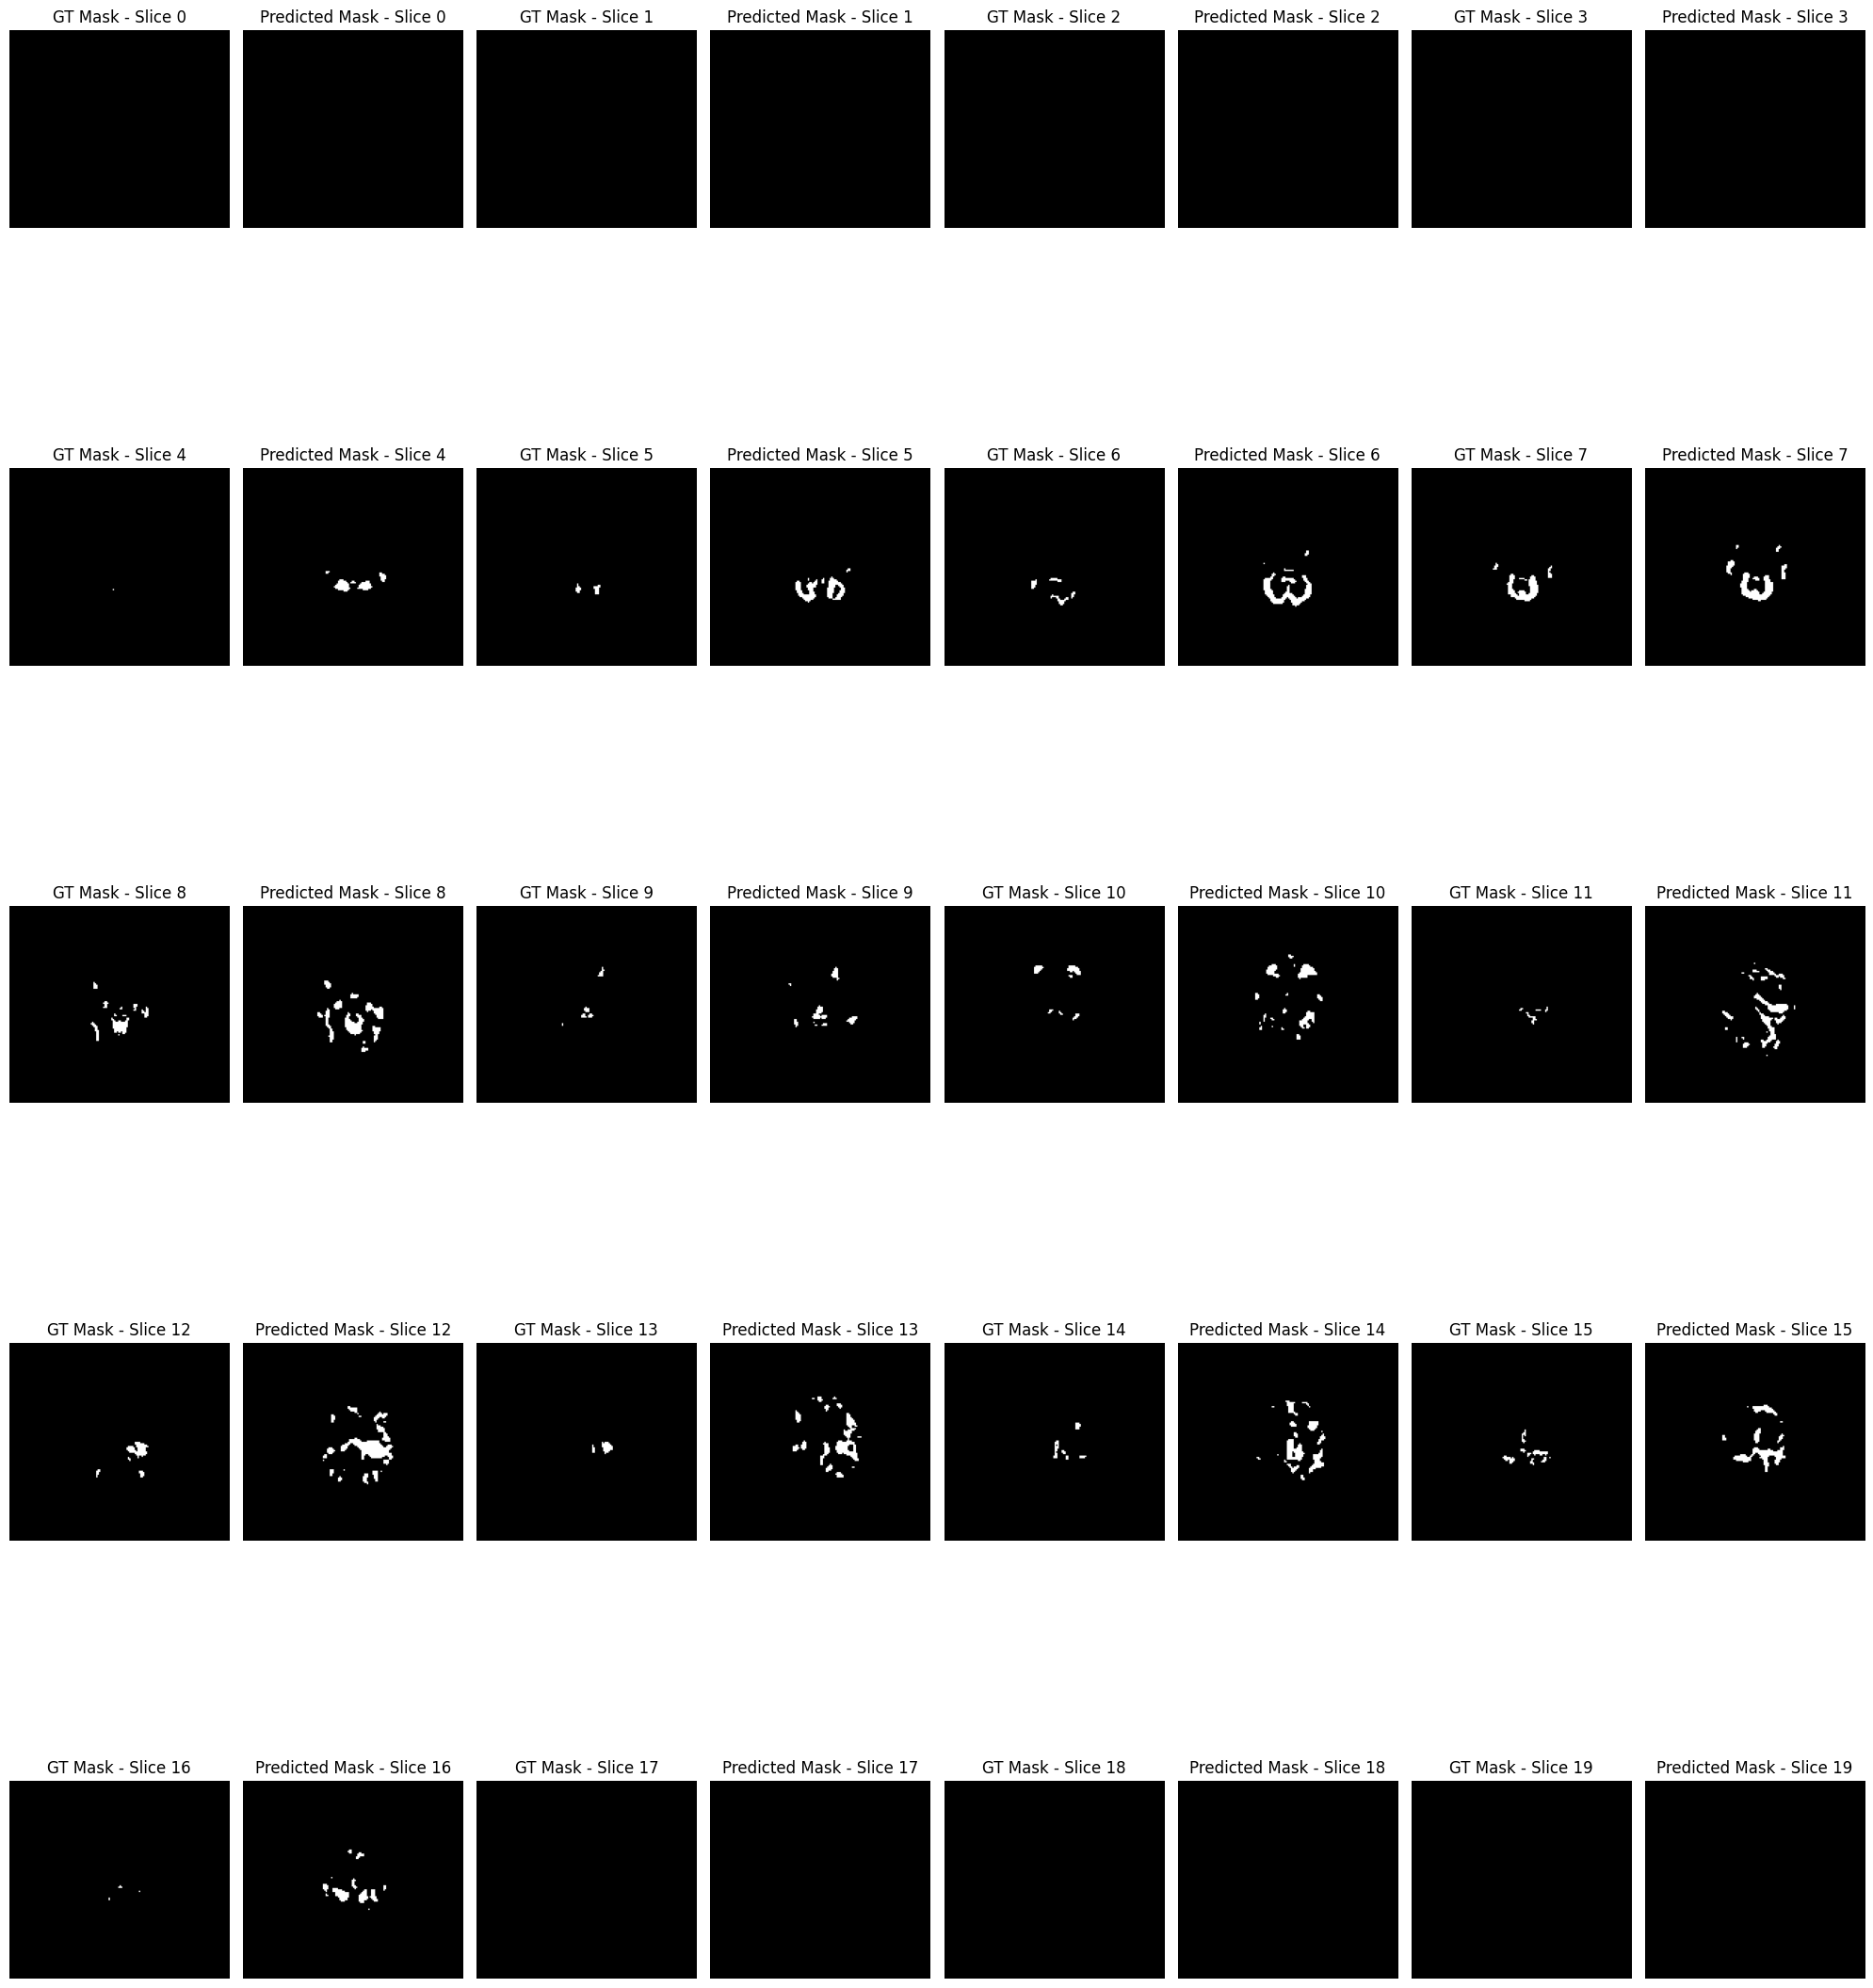

436
Dice: 0.39064499735832214
MASD: 1.9785975217819214
NSD: 0.6546816229820251


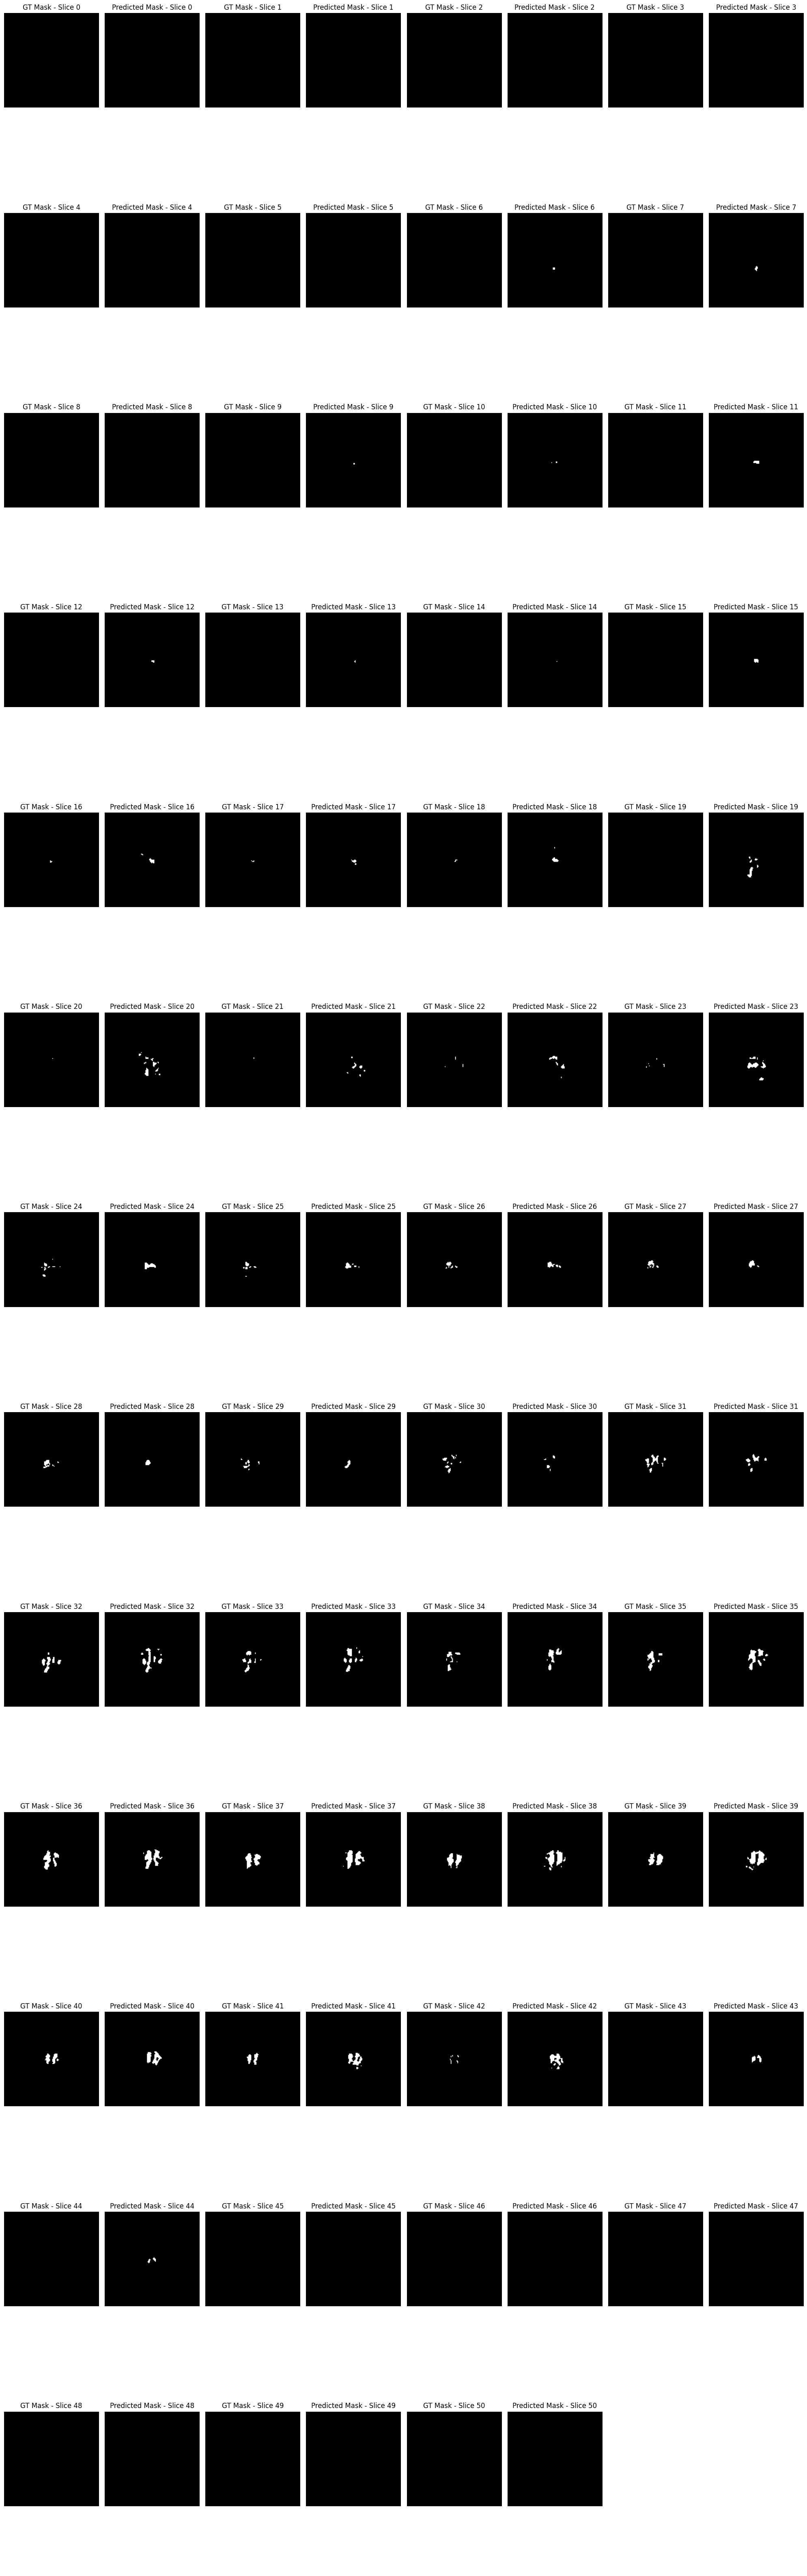

302
Dice: 0.6063737869262695
MASD: 1.3779242038726807
NSD: 0.7994652390480042


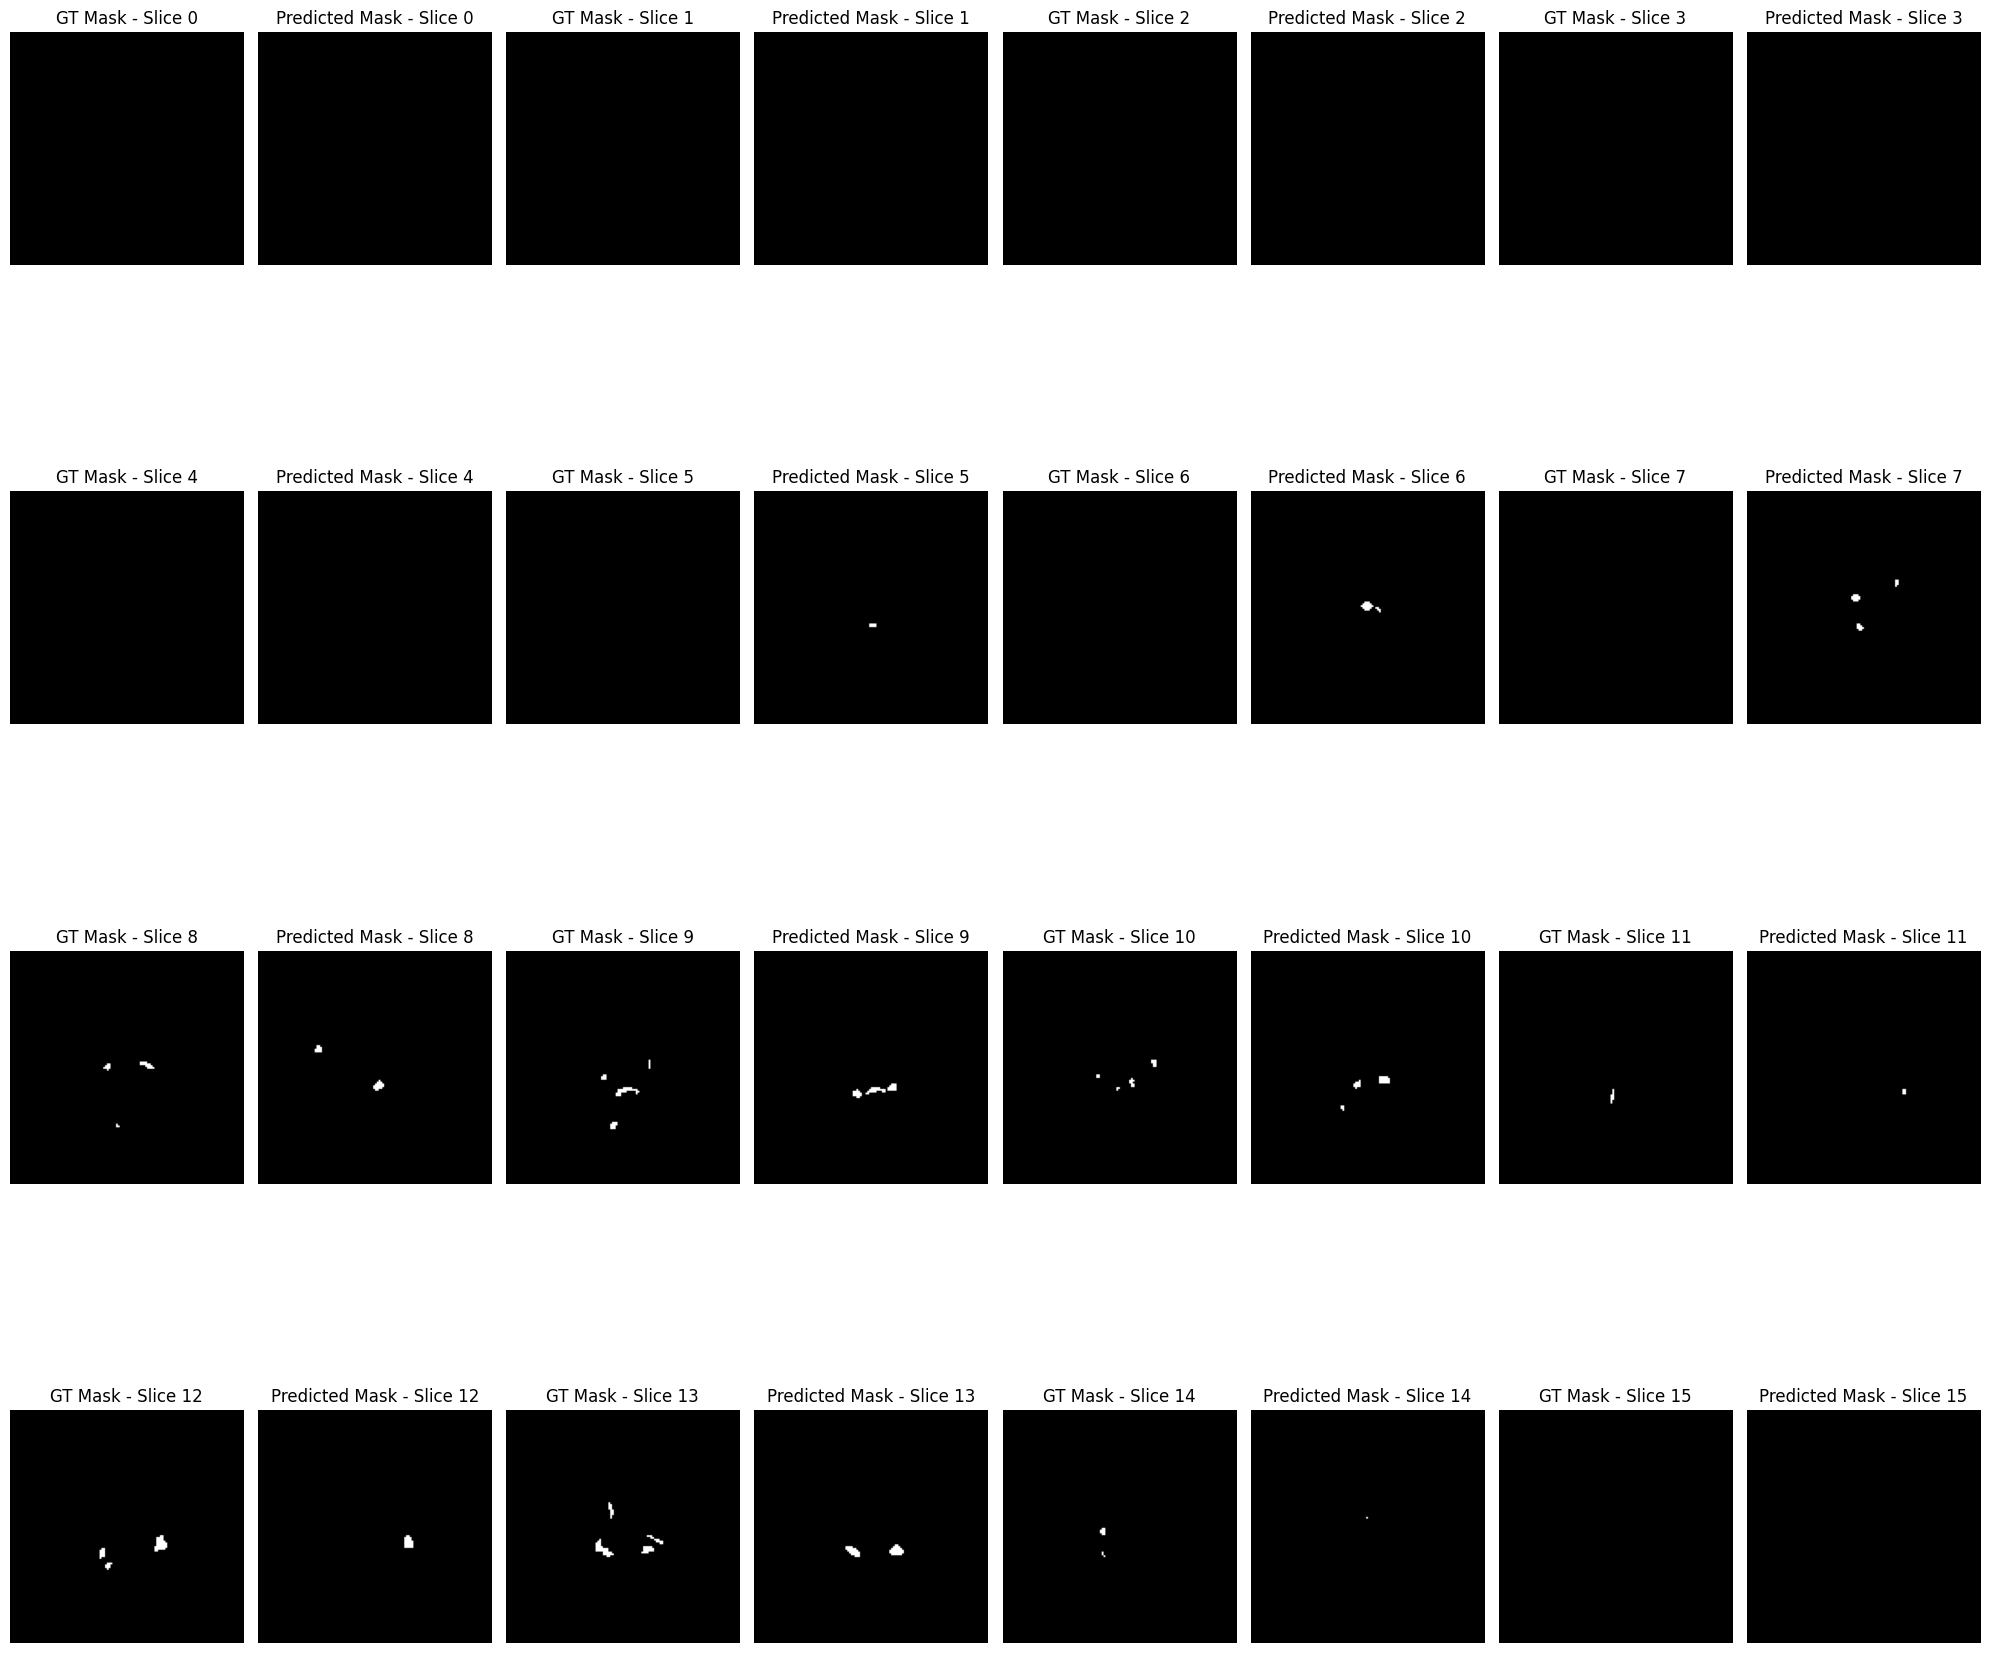

001
Dice: 0.33388981223106384
MASD: 3.188098192214966
NSD: 0.5292153358459473


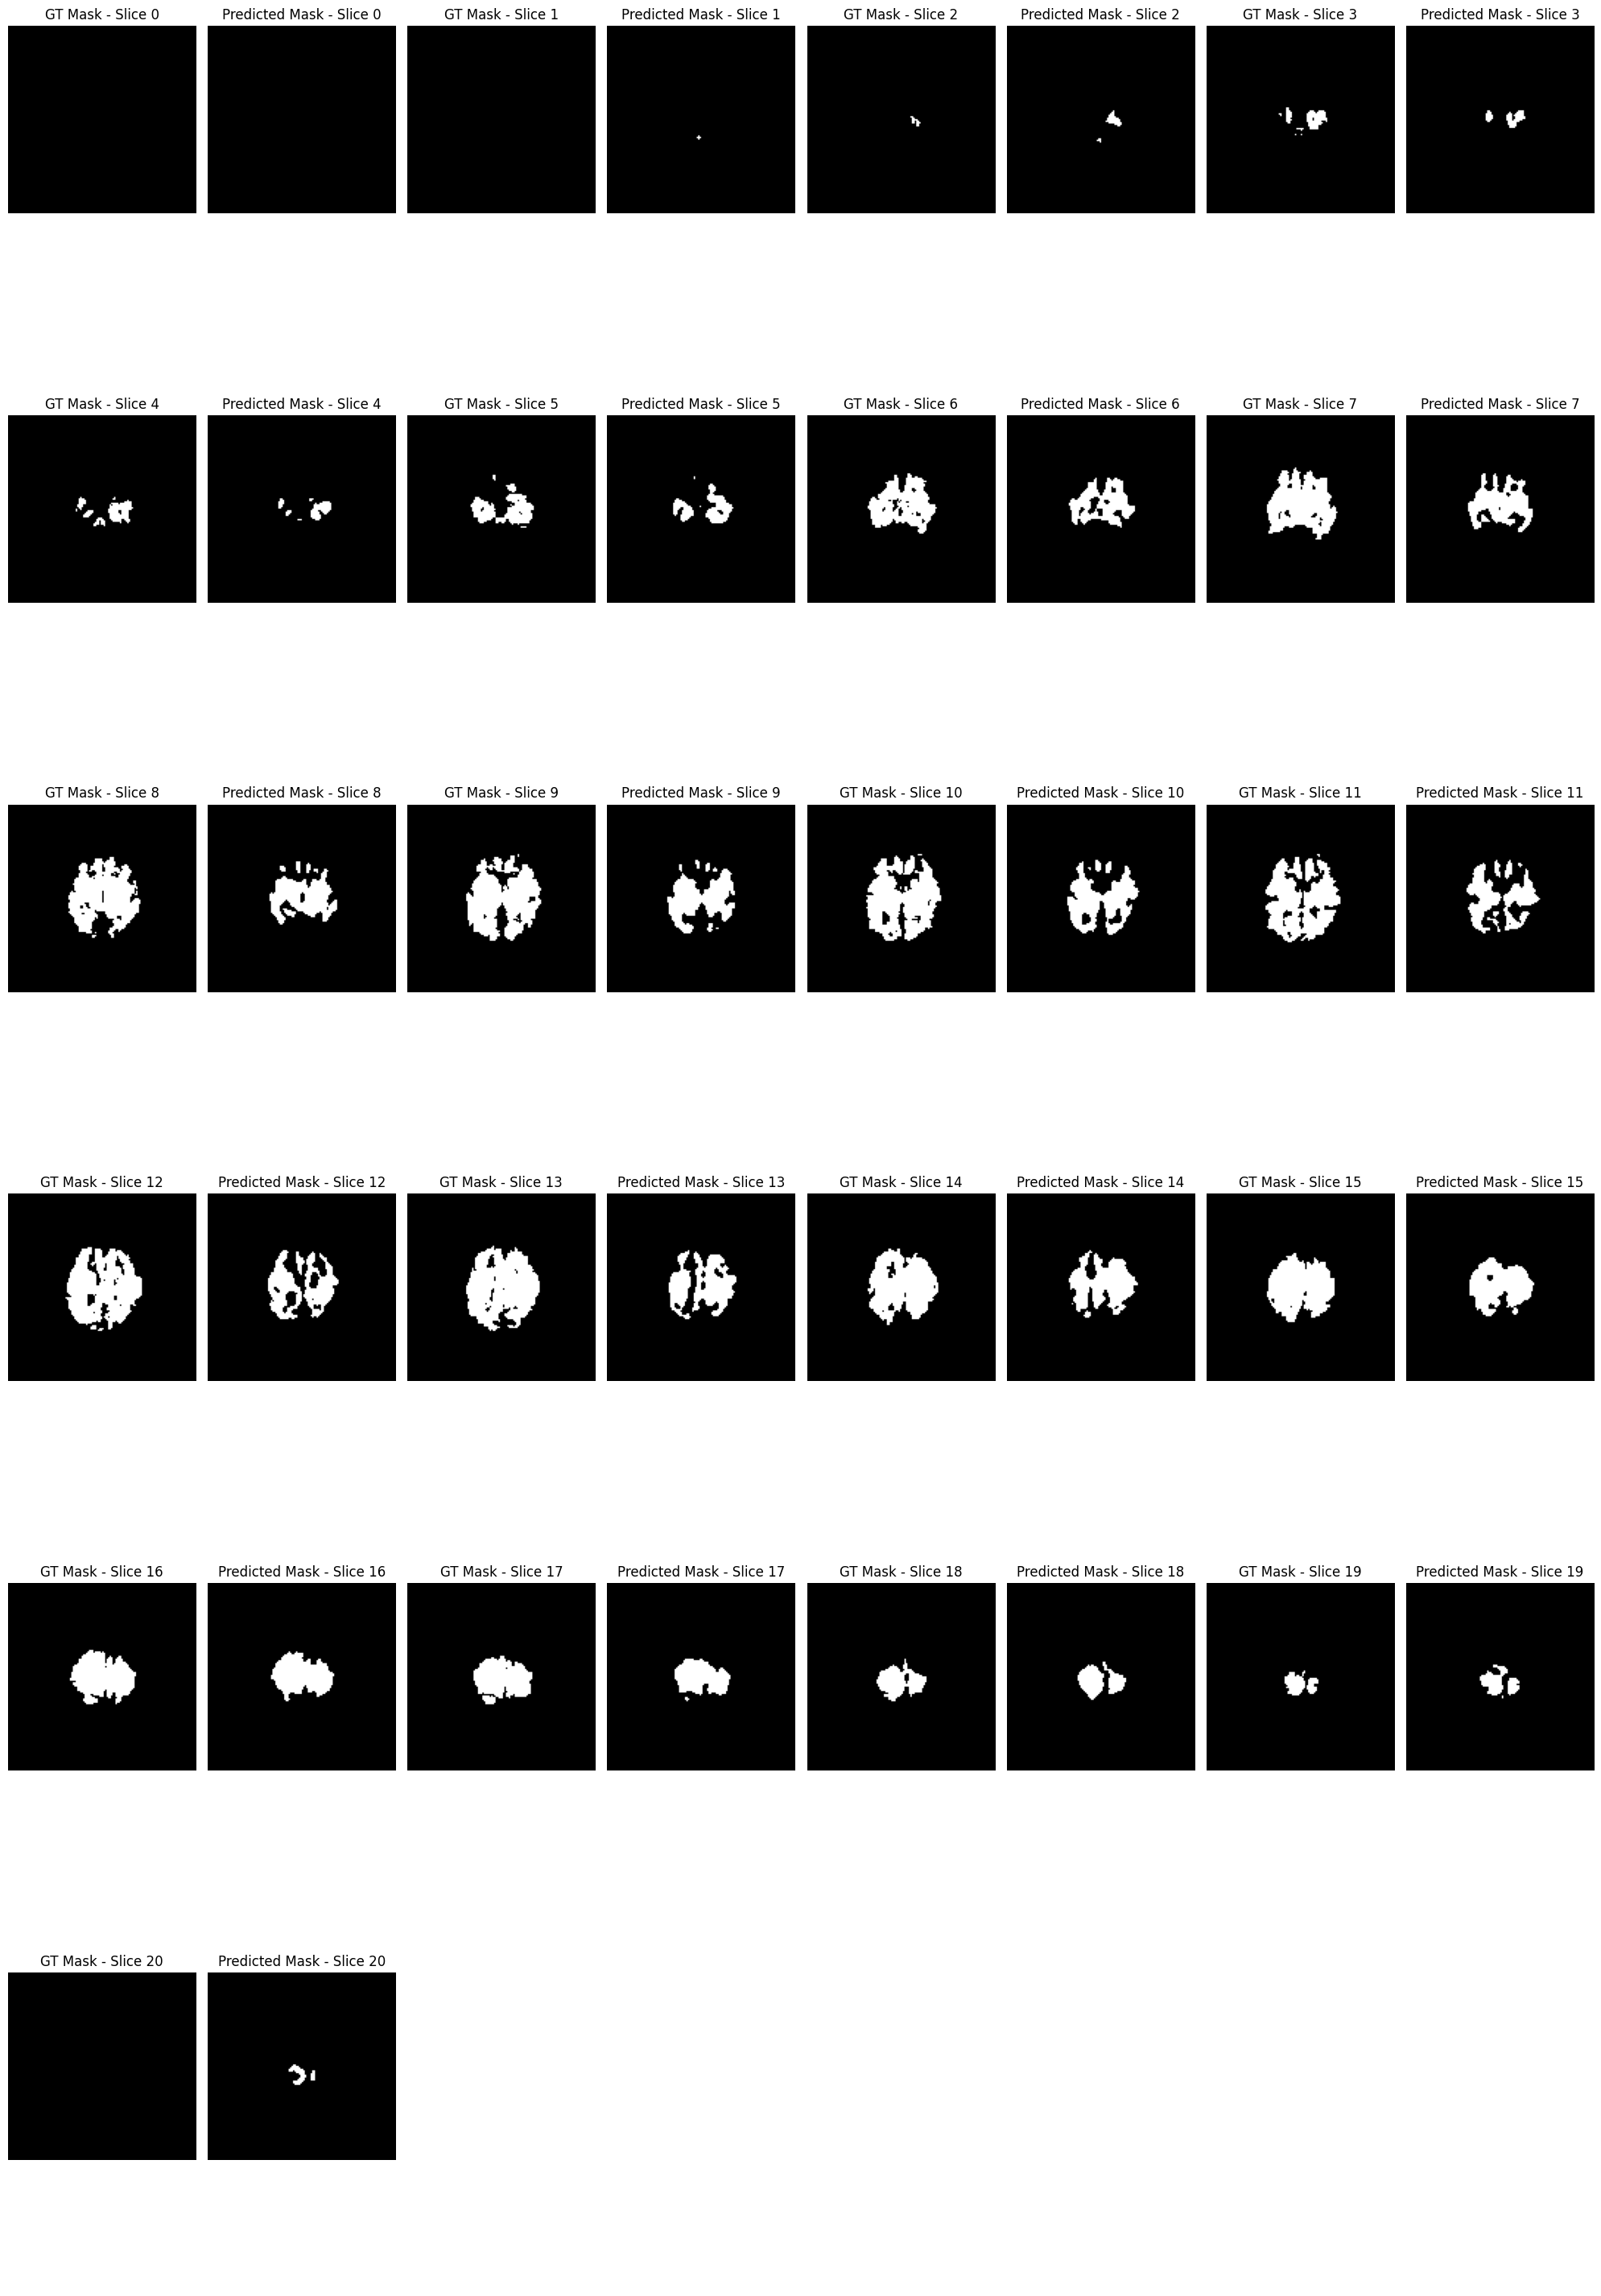

002
Dice: 0.794199526309967
MASD: 0.8440666198730469
NSD: 0.9394435286521912

Average Metrics
Dice 0.5312770307064056
MASD 1.8471716344356537
NSD 0.7307014316320419


In [5]:
dice_l = []
masd_l = []
nsd_l = []
for uid in uids:
    image_set = reassemble_to_3d(f'{DATA_ROOT}/BONBID2024_Val/Z_ADC', uid)

    for i in range(image_set.shape[0]):
        image = np.expand_dims(resample(np.stack([image_set[i]])),axis=0)

        image = torch.tensor(image).to(DEVICE)

        output = model(image)
        pred = (output >= 0.5).float()


        preds_3d[uid].append(crop_to_original(pred.cpu().detach().numpy()[0],original_size=tuple(image_set.shape[1:]))[0])

        # print(pred.shape)
        # print(np.array(preds_3d[uid]).shape)
        if len(preds_3d[uid]) == image_set.shape[0]:
            preds_3d[uid] = np.stack(preds_3d[uid])
            dice = monai.metrics.DiceMetric(include_background=True,ignore_empty=False)
            masd = monai.metrics.SurfaceDistanceMetric(include_background=False, symmetric = True)
            nsd = monai.metrics.SurfaceDiceMetric(include_background=False, distance_metric="euclidean", class_thresholds=[2])
            show_all_slices_in_grid(masks_3d[uid],preds_3d[uid])
            preds_mask = torch.tensor(preds_3d[uid]).unsqueeze(0).unsqueeze(0)
            true_mask = torch.tensor(masks_3d[uid]).unsqueeze(0).unsqueeze(0)
            print(uid)
            dice_val = dice(preds_mask,true_mask).item()
            masd_val = masd(preds_mask,true_mask).item()
            nsd_val = nsd(preds_mask,true_mask).item()
            dice_l.append(dice_val)
            masd_l.append(masd_val)
            nsd_l.append(nsd_val)
            print("Dice:",dice_val)
            print("MASD:",masd_val)
            print("NSD:",nsd_val)
print()
print("Average Metrics")
print("Dice",np.mean(dice_l))
print("MASD",np.mean(masd_l))
print("NSD",np.mean(nsd_l))